In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
%reload_ext autoreload

import json
from datetime import datetime
import argparse
from scipy import ndimage
import torch
import torchvision
import os
import torchvision.transforms as transforms
from collections import defaultdict, OrderedDict
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import time
import random
import yaml
import logging
import shutil
from models.resnet import NormalizeLayer, Mixed
from models.simple import reseed
from utils.utils import *
from utils.image_helper import ImageHelper
from utils.text_helper import TextHelper
logger = logging.getLogger('logger')
from prompt_toolkit import prompt
from training import *
from utils.utils import *
from IPython.display import Image
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

pilimage = ToPILImage()
import hiddenlayer as hl

from tqdm import tqdm_notebook as tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from models.smoothnet import sresnet
from utils.pipa_loader import *
from collections import defaultdict
from skimage import io, transform
plt.ion()
import matplotlib.patches as mpatches

from data.celeba import CelebA


In [9]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = tensor.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unnorm = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [13]:
helper = ImageHelper(params=yaml.load(open('utils/params_celeba.yaml'), Loader=yaml.FullLoader), 
                     name='none',current_time=datetime.now())

In [5]:
# helper.load_celeba()

In [15]:
celeba_test = CelebA('./data/celeba', split='train', target_type=['identity'], download=True)

Files already downloaded and verified


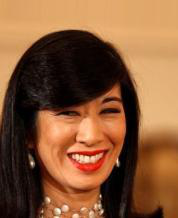

In [19]:
celeba_test[0][0][2]

In [20]:
from mtcnn import MTCNN



Using TensorFlow backend.


In [21]:
celeba_test.landmarks_align[0]

tensor([ 69, 109, 106, 113,  77, 142,  73, 152, 108, 154])

In [15]:
a=[1,2,3,4,5]

In [16]:
set(a).difference([3])

{1, 2, 4, 5}

In [17]:
a

[1, 2, 3, 4, 5]

In [22]:
count = 0
for key, value in celeba_test.identities_dict.items():
    if len(value)<=1:
        count+=1

In [23]:
count

36

In [24]:
len(helper.test_dataset.identities_dict)

1000

In [26]:
helper.test_dataset.identities_dict.keys()

dict_keys([7760, 7988, 5858, 4930, 6192, 9739, 7407, 10154, 6190, 7862, 5872, 5010, 6221, 8659, 9411, 5941, 5241, 5774, 8777, 8533, 10001, 6177, 9603, 5301, 5624, 7712, 9874, 8154, 8745, 7570, 7037, 7776, 6272, 6011, 7269, 7736, 10075, 6433, 9864, 9466, 9102, 5568, 9827, 6959, 9260, 5778, 8124, 9584, 7752, 8445, 8561, 9284, 7900, 9343, 9173, 8880, 6390, 7598, 5458, 7370, 5665, 9692, 5735, 9737, 10027, 4973, 9453, 7236, 6743, 5075, 5148, 5773, 8297, 6846, 8918, 7910, 6399, 5354, 9073, 6313, 8963, 9407, 10152, 9499, 6472, 5567, 8027, 6789, 8101, 9799, 7306, 6794, 8416, 6075, 9717, 5840, 9755, 7908, 5478, 5676, 8625, 5462, 8244, 7592, 7986, 8395, 9768, 8985, 5100, 5929, 7206, 5260, 7130, 9988, 7121, 6726, 6824, 7327, 8255, 9856, 5275, 9909, 7111, 8188, 7258, 5651, 6093, 9232, 8726, 6135, 5958, 9010, 6766, 5768, 6745, 5975, 6010, 10090, 10059, 5524, 9394, 8421, 7050, 7362, 9763, 5224, 5614, 8344, 7062, 6638, 8164, 7002, 6676, 6057, 9400, 9621, 6506, 5158, 7912, 6187, 7567, 8757, 9762, 8621